In [4]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [5]:
df = pd.read_csv('./Data.csv')

In [6]:
sns.set_theme(
    context='talk',
    style='ticks',
    font_scale=.8,
    rc={
        'figure.figsize': (12,8)
    }
)

In [7]:
def display_side_by_side(dataframes:list,titles:list):
    html_str=''
    for df,title in zip(dataframes, titles):
        html_str+=f'<span>{title}:</span>'
        html_str+=df.to_html().replace('table','table style="display:inline"')
        html_str+="&nbsp"*10
    display(HTML(html_str))

In [8]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 08:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 08:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 08:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 08:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 08:26,3.39,17850.0,United Kingdom


In [9]:
df.describe()

,Quantity,UnitPrice,CustomerID
count,541909.000000,541909.000000,406829.000000
mean,9.552250,4.611121,15287.690570
std,218.081158,96.759853,1713.600303
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13953.000000
50%,3.000000,2.080000,15152.000000
75%,10.000000,4.130000,16791.000000
max,80995.000000,38970.000000,18287.000000


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [11]:
print(df['CustomerID'].isna().sum())

135080


In [12]:
df = df.dropna(subset=['CustomerID'])

In [13]:
df = df[(df['UnitPrice'] > 0) & (df['Quantity'] > 0)]

In [14]:
print(df.duplicated().sum())

5192


In [15]:
df = df.drop_duplicates()

In [16]:
df['CustomerID'] = df['CustomerID'].astype(int)

In [17]:
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

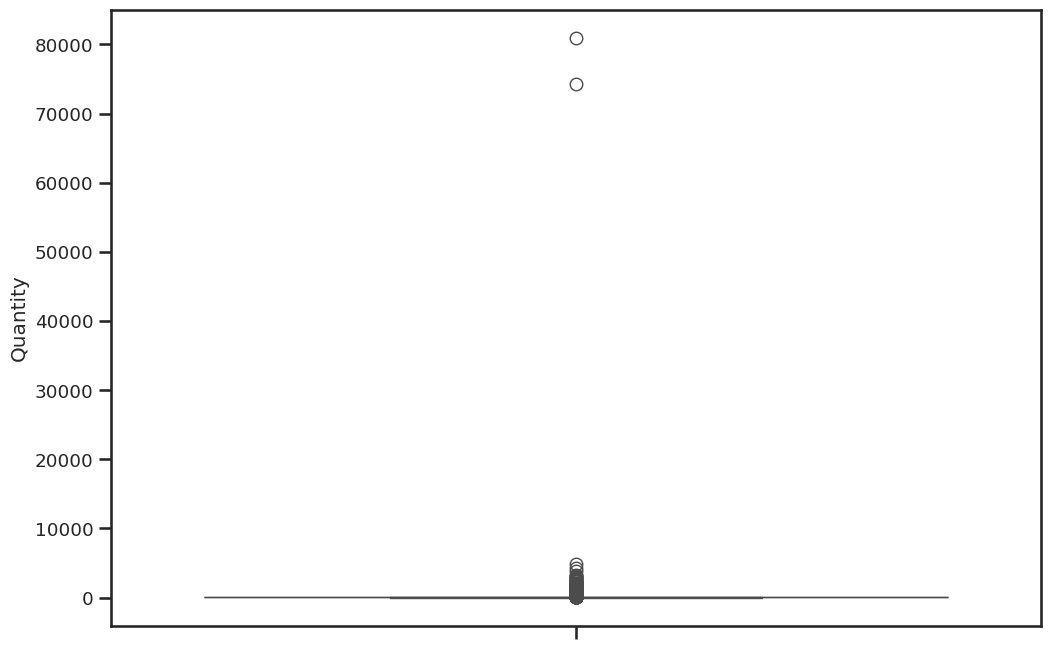

In [18]:
sns.boxplot(df['Quantity'])
plt.show()

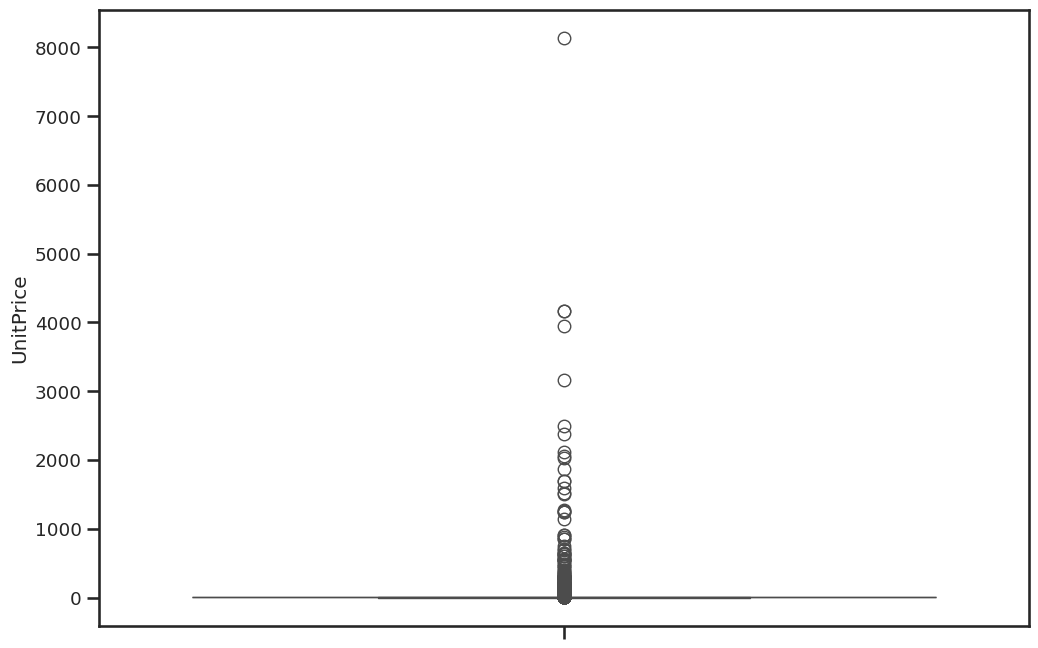

In [19]:
sns.boxplot(df['UnitPrice'])
plt.show()

In [20]:
df = df[(df['Quantity'] <= 10000) & (df['UnitPrice'] <= 5000)]

In [21]:
df['TotalPrice'] = df['Quantity'] * df['UnitPrice']

In [22]:
last_purchase_date = df['InvoiceDate'].max()
print(f"Última data de compra no dataset: {last_purchase_date}")

Última data de compra no dataset: 2011-12-09 12:50:00


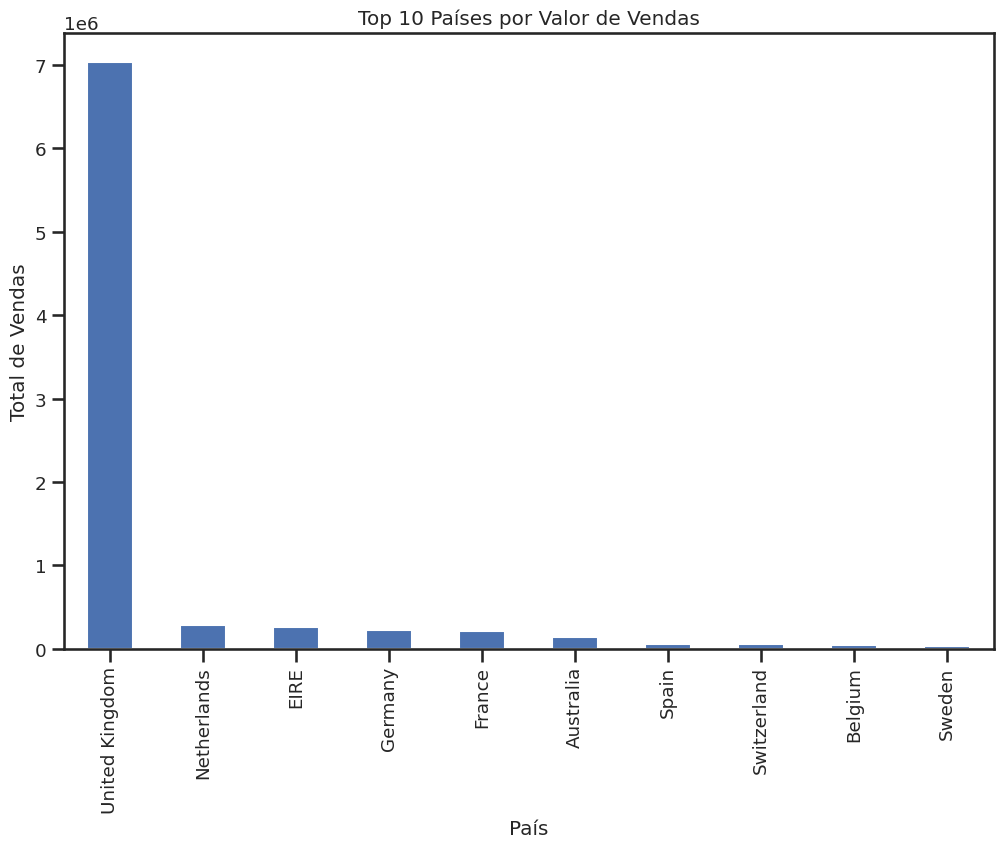

In [23]:
# 1. Top 10 países com maior valor em vendas (Gráfico de barras)
top_countries = df.groupby('Country')['TotalPrice'].sum().nlargest(10)
top_countries.plot(kind='bar', xlabel='País', ylabel='Total de Vendas', title='Top 10 Países por Valor de Vendas')
plt.show()

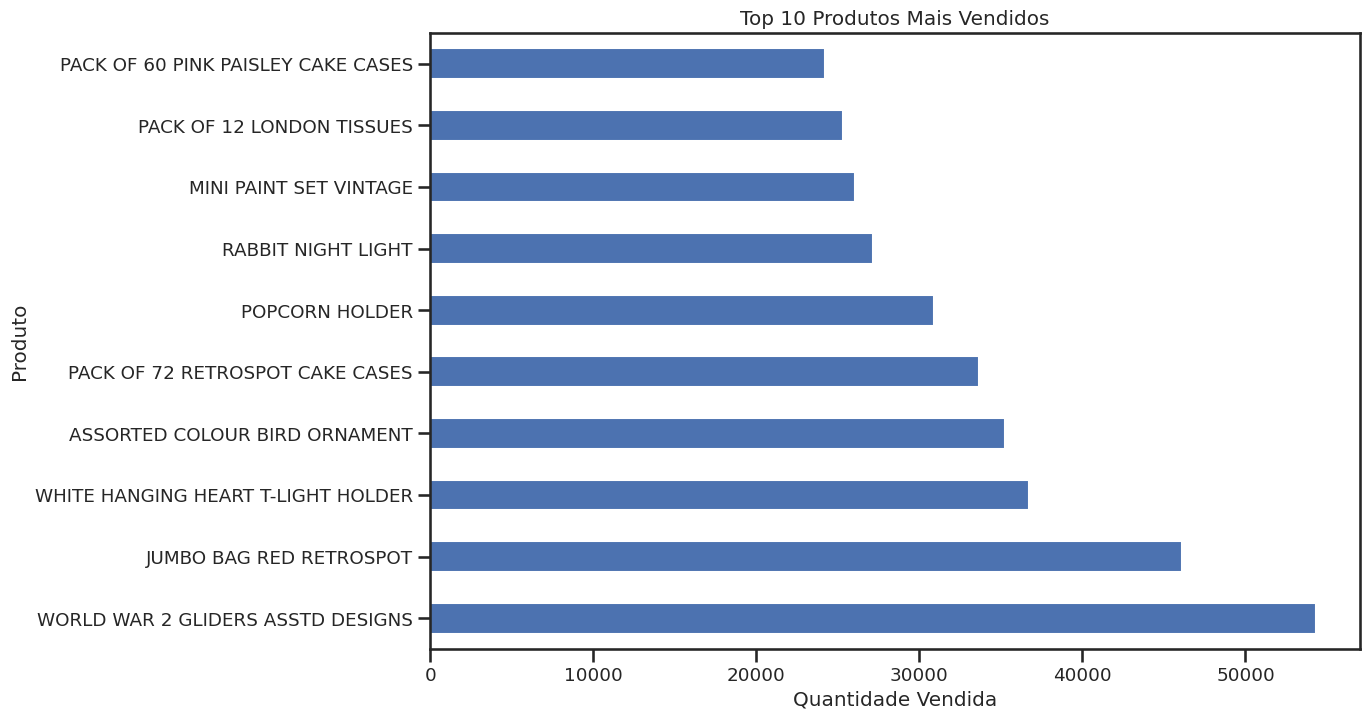

In [24]:
# 2. Top 10 produtos mais vendidos (Gráfico de barras horizontais)
top_products = df.groupby('Description')['Quantity'].sum().nlargest(10)
top_products.plot(kind='barh', xlabel='Quantidade Vendida', ylabel='Produto', title='Top 10 Produtos Mais Vendidos')
plt.show()

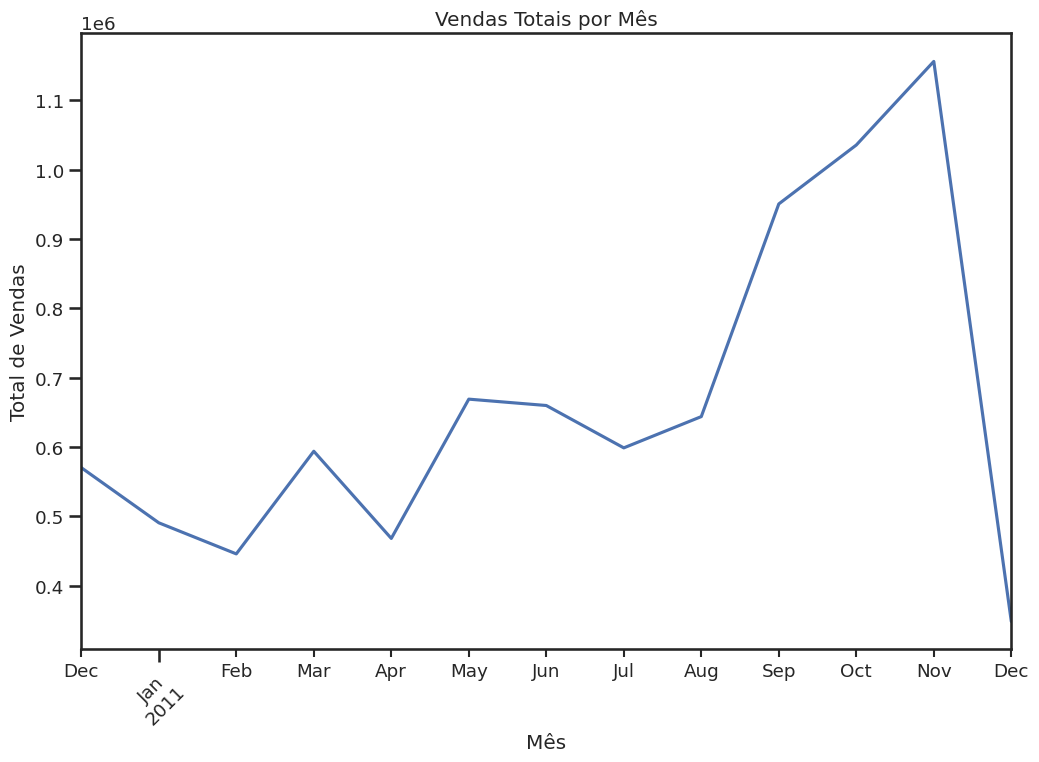

In [25]:
# 3. Valor de venda total por mês (Gráfico de linha)
df['Month'] = df['InvoiceDate'].dt.to_period('M')
sales_per_month = df.groupby('Month')['TotalPrice'].sum()
sales_per_month.plot(kind='line', xlabel='Mês', ylabel='Total de Vendas', title='Vendas Totais por Mês')
plt.xticks(rotation=45)
plt.show()

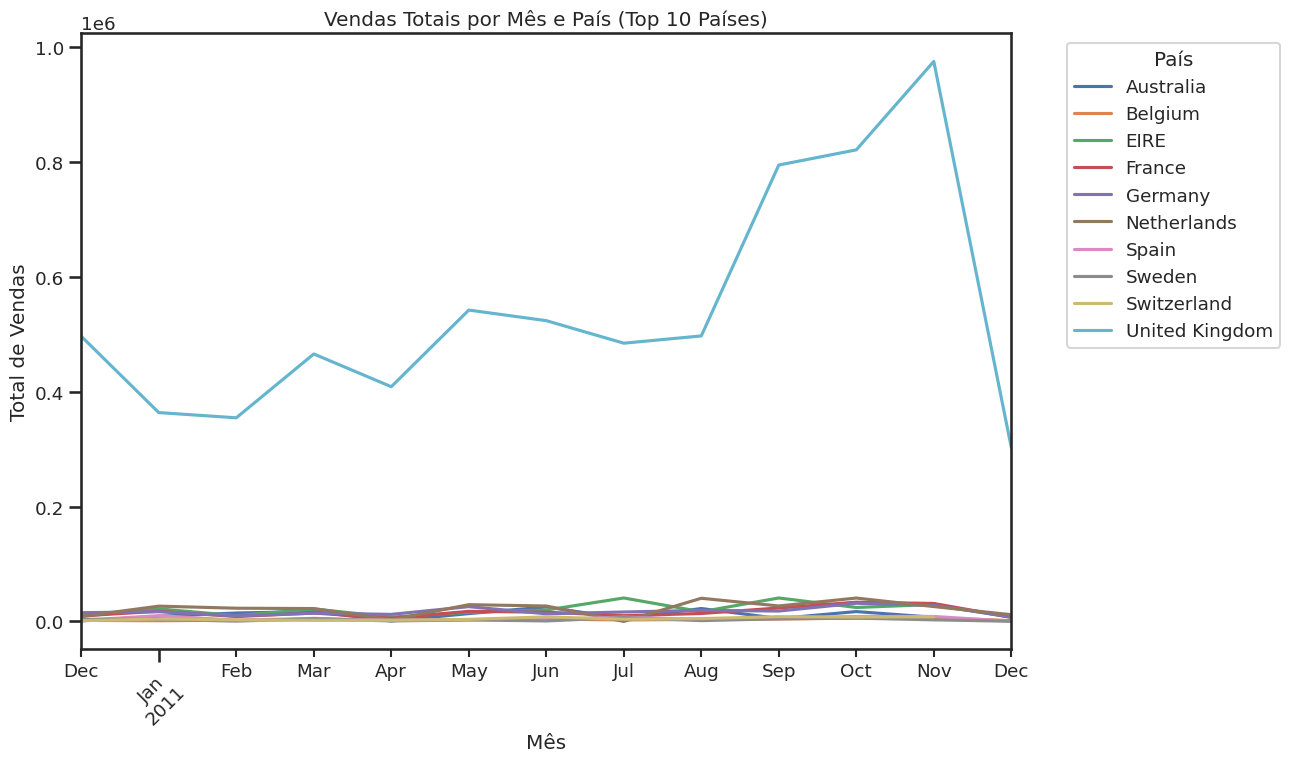

In [26]:
# 4. Valor de venda total por mês e por país (considerando top 10 países) (Gráfico de linha)
top_countries_list = top_countries.index.tolist()
sales_per_month_country = df[df['Country'].isin(top_countries_list)].groupby(['Month', 'Country'])['TotalPrice'].sum().unstack()
sales_per_month_country.plot(kind='line', xlabel='Mês', ylabel='Total de Vendas', title='Vendas Totais por Mês e País (Top 10 Países)')
plt.xticks(rotation=45)
plt.legend(title='País', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

In [27]:
# 1. Agrupe por cliente e InvoiceNo, obtendo data e preço total do pedido
rfm_data = df.groupby(['CustomerID', 'InvoiceNo']).agg({
    'InvoiceDate': 'max',
    'TotalPrice': 'sum'
}).reset_index()

In [28]:
if 'current_date' not in locals():
    current_date = df['InvoiceDate'].max()

# 2. Calcule RFM
rfm_table = rfm_data.groupby('CustomerID').agg({
    'InvoiceDate': lambda date: (current_date - date.max()).days,
    'InvoiceNo': 'count',
    'TotalPrice': 'mean'
}).rename(columns={
    'InvoiceDate': 'Recency',
    'InvoiceNo': 'Frequency',
    'TotalPrice': 'Monetary'
}).reset_index()

print(rfm_table.head())

   CustomerID  Recency  Frequency     Monetary
0       12347        1          7   615.714286
1       12348       74          4   449.310000
2       12349       18          1  1757.550000
3       12350      309          1   334.400000
4       12352       35          8   313.255000


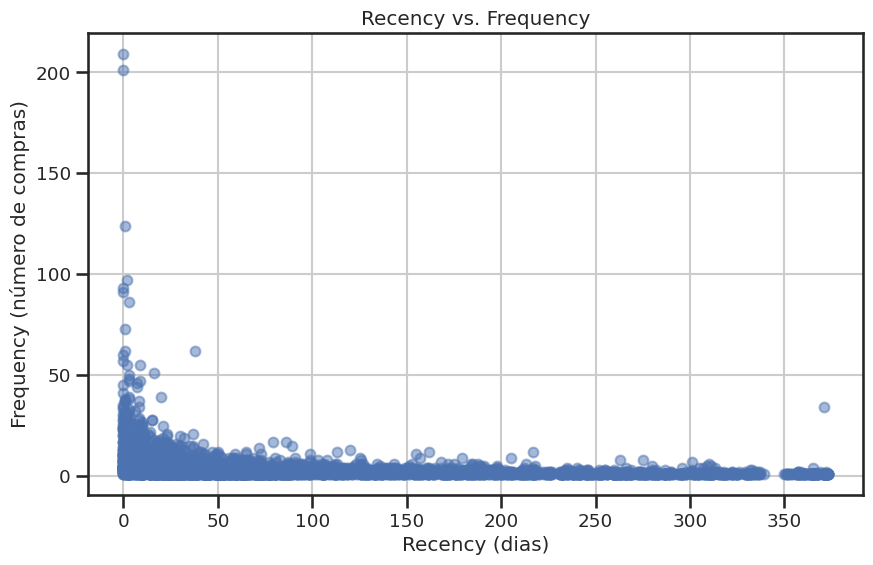

In [29]:
# Plotando gráfico de dispersão (Recency vs. Frequency)
plt.figure(figsize=(10, 6))
plt.scatter(rfm_table['Recency'], rfm_table['Frequency'], s=50, alpha=0.5)
plt.title('Recency vs. Frequency')
plt.xlabel('Recency (dias)')
plt.ylabel('Frequency (número de compras)')
plt.grid(True)
plt.show()

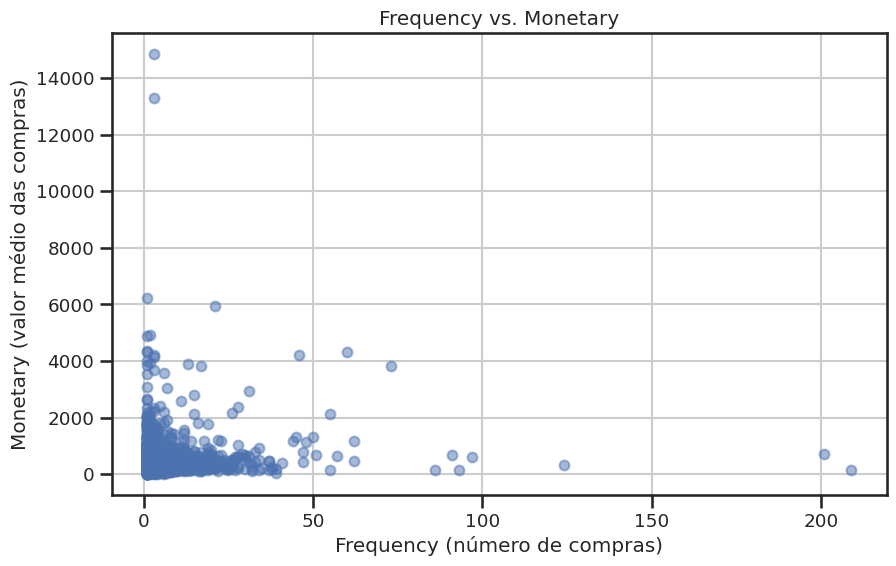

In [30]:
# Plotando gráfico de dispersão (Frequency vs. Monetary)
plt.figure(figsize=(10, 6))
plt.scatter(rfm_table['Frequency'], rfm_table['Monetary'], s=50, alpha=0.5)
plt.title('Frequency vs. Monetary')
plt.xlabel('Frequency (número de compras)')
plt.ylabel('Monetary (valor médio das compras)')
plt.grid(True)
plt.show()

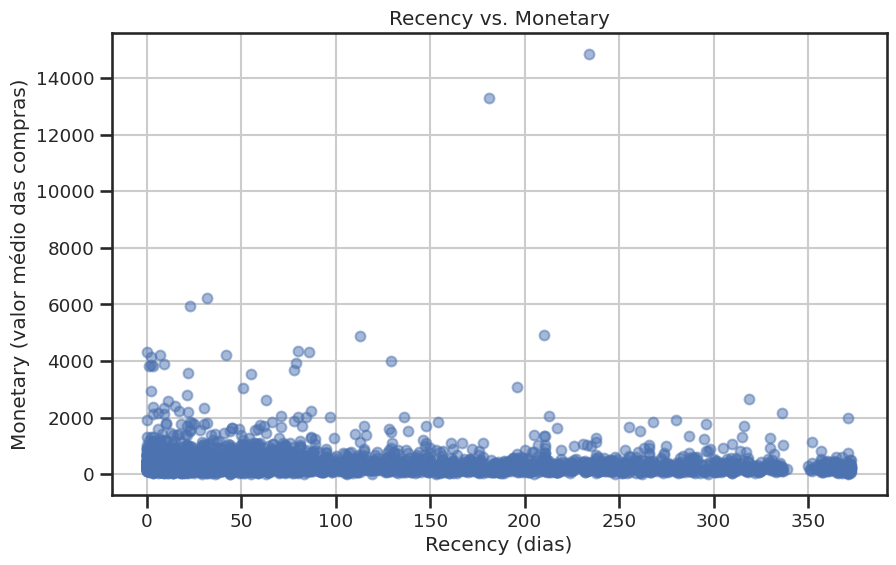

In [31]:
# Plotando gráfico de dispersão (Recency vs. Monetary)
plt.figure(figsize=(10, 6))
plt.scatter(rfm_table['Recency'], rfm_table['Monetary'], s=50, alpha=0.5)
plt.title('Recency vs. Monetary')
plt.xlabel('Recency (dias)')
plt.ylabel('Monetary (valor médio das compras)')
plt.grid(True)
plt.show()